In [ ]:
#Data Preparation and Cleaning
!pip install pydicom
import os
import cv2
import pandas as pd
import pydicom  

def dicom_to_png(dicom_path, png_path):
    """Convert a single DICOM file to PNG format."""
    try:
        dcm = pydicom.dcmread(dicom_path)
        img = dcm.pixel_array
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        cv2.imwrite(png_path, img)
    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")

def convert_dataset(dicom_dir, out_dir, csv_annotations):

    ## converting dicom in csv to png
    os.makedirs(out_dir, exist_ok=True)
    
    annots = pd.read_csv(csv_annotations)

    for i, row in annots.iterrows():
        dicom_file = os.path.join(dicom_dir, row['image_id'] + ".dicom")
        png_file = os.path.join(out_dir, row['image_id'] + ".png")

        if os.path.exists(dicom_file):
            dicom_to_png(dicom_file, png_file)
        else:
            print(f"File not found: {dicom_file}")

In [ ]:
# Data Handling and Abstraction
from torch.utils.data import Dataset
from PIL import Image
import torch
class CSRClassificationDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):  
        return len(self.image_paths)

    def __getitem__(self, idx):  
        image_path = self.image_paths[idx] 
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(label, dtype=torch.float32) 
        return image, label



In [20]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Model Definition and Initialization
%pip install "numpy<2.0" --force-reinstall

import torch.nn as nn
import torchvision.models as models

def build_resnet(num_classes):
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes),
        nn.Sigmoid()
    )
    return model

  Using cached numpy-1.26.4-cp313-cp313-win_amd64.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-dtypes 0.5.3 requires numpy>=2.1.0; python_version >= "3.13", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [26]:
pip install torch==2.8.0 torchvision --upgrade


Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Data Loading, Transformation, and Model Initialization 
# %pip install torch torchvision

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

train_dir = r"D:\chest_xray\train"
val_dir   = r"D:\chest_xray\val"
test_dir  = r"D:\chest_xray\test"


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


full_train_dataset = datasets.ImageFolder(train_dir, transform=transform)
full_val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
full_test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

max_images = 200  
train_dataset = Subset(full_train_dataset, range(min(len(full_train_dataset), max_images)))
val_dataset   = Subset(full_val_dataset, range(min(len(full_val_dataset), max_images)))
test_dataset  = Subset(full_test_dataset, range(min(len(full_test_dataset), max_images)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", full_train_dataset.classes)  


num_classes = len(full_train_dataset.classes)  
model = models.resnet18(weights=None) 

in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Model Training and Evaluation
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3):
    for epoch in range(epochs):
       
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return model

model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30)


model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f" Test Accuracy: {100 * correct / total:.2f}%")



Classes: ['NORMAL', 'PNEUMONIA']
Using device: cpu
Epoch 1: Train Loss=0.3735, Train Acc=0.8450, Val Loss=0.7694, Val Acc=0.5000
Epoch 2: Train Loss=0.0447, Train Acc=1.0000, Val Loss=1.3277, Val Acc=0.5000
Epoch 3: Train Loss=0.0093, Train Acc=1.0000, Val Loss=2.0446, Val Acc=0.5000
Epoch 4: Train Loss=0.0036, Train Acc=1.0000, Val Loss=2.6106, Val Acc=0.5000
Epoch 5: Train Loss=0.0016, Train Acc=1.0000, Val Loss=3.0414, Val Acc=0.5000
Epoch 6: Train Loss=0.0011, Train Acc=1.0000, Val Loss=3.3775, Val Acc=0.5000
Epoch 7: Train Loss=0.0007, Train Acc=1.0000, Val Loss=3.6357, Val Acc=0.5000
Epoch 8: Train Loss=0.0005, Train Acc=1.0000, Val Loss=3.8411, Val Acc=0.5000
Epoch 9: Train Loss=0.0004, Train Acc=1.0000, Val Loss=4.0042, Val Acc=0.5000
Epoch 10: Train Loss=0.0003, Train Acc=1.0000, Val Loss=4.1491, Val Acc=0.5000
Epoch 11: Train Loss=0.0003, Train Acc=1.0000, Val Loss=4.2704, Val Acc=0.5000
Epoch 12: Train Loss=0.0002, Train Acc=1.0000, Val Loss=4.3881, Val Acc=0.5000
Epoch 13: 

In [ ]:
#YOLO Model 
%pip install ultralytics
from ultralytics import YOLO
import torch, os

print("Torch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

dataset_root = r"D:\chest_xray"
train_dir = os.path.join(dataset_root, "train")
val_dir   = os.path.join(dataset_root, "val")
test_dir  = os.path.join(dataset_root, "test") 

model = YOLO("yolov8n-cls.pt")

model.train(
    data=dataset_root,
    epochs=20,
    imgsz=224,
    batch=32,
    name="classification_model_fixed"
)

metrics = model.val(data=dataset_root, split="test", imgsz=224, batch=32)
print(metrics)


  Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.
Torch version: 2.8.0+cpu
GPU available: False
Ultralytics 8.3.203  Python-3.13.7 torch-2.8.0+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\chest_xray, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=

In [ ]:
#Grad-CAM Setup and Visualization
# %pip install grad-cam 

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import warnings
import os

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


warnings.filterwarnings("ignore", category=UserWarning)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model = resnet18(weights=None)  
from torchvision.models import ResNet18_Weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()
model.to(device)


target_layer = model.layer4[-1]


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#Visualization Execution and Output
def run_gradcam(image_path):
    
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    rgb_img = np.array(img.resize((224, 224))) / 255.0  # For visualization
    
  
    print("Running Grad-CAM on:", image_path)
    print("Original image shape:", np.array(img).shape)
    print("Input tensor shape:", input_tensor.shape)
    
   
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]
    
  
    visualization = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)
    
    return rgb_img, visualization


sample_images = [
    r"D:\chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg",
    r"D:\chest_xray\val\NORMAL\NORMAL2-IM-1427-0001.jpeg"
]


num_images = len(sample_images)
plt.figure(figsize=(10, 5*num_images)) 

for i, img_path in enumerate(sample_images):
    if not os.path.exists(img_path):
        print("Image not found:", img_path)
        continue
    
    orig, heatmap = run_gradcam(img_path)
    
    
    plt.subplot(num_images, 2, 2*i+1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis("off")
    
    
    plt.subplot(num_images, 2, 2*i+2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM")
    plt.axis("off")
    
plt.tight_layout()
plt.show()


save_dir = r"D:\gradcam_outputs"

os.makedirs(save_dir, exist_ok=True)

for img_path in sample_images:
    if not os.path.exists(img_path):
        continue
    _, heatmap = run_gradcam(img_path)
    filename = os.path.basename(img_path).replace(".jpeg", "_gradcam.jpeg")
    save_path = os.path.join(save_dir, filename)
    Image.fromarray(heatmap).save(save_path)
    print("Saved Grad-CAM image:", save_path)


Using device: cpu
Running Grad-CAM on: D:\chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg
Original image shape: (592, 968, 3)
Input tensor shape: torch.Size([1, 3, 224, 224])
Running Grad-CAM on: D:\chest_xray\val\NORMAL\NORMAL2-IM-1427-0001.jpeg
Original image shape: (1416, 1776, 3)
Input tensor shape: torch.Size([1, 3, 224, 224])


<Figure size 1000x1000 with 4 Axes>

Running Grad-CAM on: D:\chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg
Original image shape: (592, 968, 3)
Input tensor shape: torch.Size([1, 3, 224, 224])
Saved Grad-CAM image: D:\gradcam_outputs\person1946_bacteria_4874_gradcam.jpeg
Running Grad-CAM on: D:\chest_xray\val\NORMAL\NORMAL2-IM-1427-0001.jpeg
Original image shape: (1416, 1776, 3)
Input tensor shape: torch.Size([1, 3, 224, 224])
Saved Grad-CAM image: D:\gradcam_outputs\NORMAL2-IM-1427-0001_gradcam.jpeg


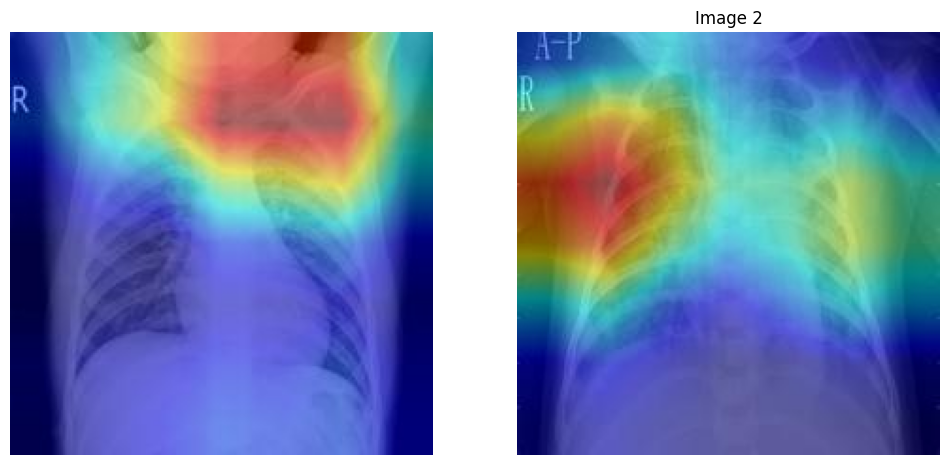

In [ ]:
#Result Visualization and Display
%matplotlib inline
import glob

image_folder = r"D:\gradcam_outputs"
image_paths = glob.glob(image_folder + "/*.jpeg")

plt.figure(figsize=(12, 6))
for i, path in enumerate(image_paths):
    img = Image.open(path)
    plt.subplot(1, len(image_paths), i+1)
    plt.imshow(img)
    plt.axis("off")
plt.title(f"Image {i+1}")
plt.show()



In [1]:
streamlit run app.py

SyntaxError: invalid syntax (3737097518.py, line 1)